# 02 - Quality Control

**COVID-19 GSE171524 Single-Cell Analysis**

This notebook performs quality control on the raw snRNA-seq data.

## Objectives
1. Calculate QC metrics (n_genes, n_counts, pct_mito, pct_ribo)
2. Apply MAD-based filtering (appropriate for snRNA-seq)
3. Detect doublets with Scrublet per sample
4. Filter low-quality cells and doublets
5. Save as `adata_qc.h5ad`

## snRNA-seq Considerations
- Lower mitochondrial content expected (nuclei vs whole cells)
- Different UMI/gene distributions compared to scRNA-seq

In [1]:
# Import libraries
import os
import sys
import warnings
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

warnings.filterwarnings('ignore')

# Add scripts to path
sys.path.insert(0, '../scripts')
from utils import calculate_qc_metrics, filter_cells_mad, run_scrublet, mad_filter
from plotting import plot_qc_metrics

# Settings
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=100, facecolor='white')

print(f"Scanpy version: {sc.__version__}")

Scanpy version: 1.11.5


In [2]:
# Define paths
INPUT_PATH = Path('../data/processed_data/adata_raw.h5ad')
OUTPUT_DIR = Path('../data/processed_data')
FIGURE_DIR = Path('../results/figures/qc')
FIGURE_DIR.mkdir(parents=True, exist_ok=True)

# Load raw data
print(f"Loading: {INPUT_PATH}")
adata = sc.read_h5ad(INPUT_PATH)
print(f"\nLoaded: {adata.n_obs:,} cells, {adata.n_vars:,} genes")

Loading: ../data/processed_data/adata_raw.h5ad

Loaded: 116,314 cells, 34,546 genes


## Calculate QC Metrics

In [3]:
# Identify mitochondrial and ribosomal genes
adata.var['mt'] = adata.var_names.str.startswith('MT-')
adata.var['ribo'] = adata.var_names.str.contains('^RP[SL]', regex=True)

print(f"Mitochondrial genes: {adata.var['mt'].sum()}")
print(f"Ribosomal genes: {adata.var['ribo'].sum()}")

# Show mito genes
print(f"\nMitochondrial genes found:")
print(adata.var_names[adata.var['mt']].tolist())

Mitochondrial genes: 13
Ribosomal genes: 102

Mitochondrial genes found:
['MT-ND1', 'MT-ND2', 'MT-CO1', 'MT-CO2', 'MT-ATP8', 'MT-ATP6', 'MT-CO3', 'MT-ND3', 'MT-ND4L', 'MT-ND4', 'MT-ND5', 'MT-ND6', 'MT-CYB']


In [4]:
# Calculate QC metrics
sc.pp.calculate_qc_metrics(
    adata,
    qc_vars=['mt', 'ribo'],
    percent_top=None,
    log1p=False,
    inplace=True
)

print("QC metrics calculated:")
print(adata.obs.columns.tolist())

QC metrics calculated:
['sample_id', 'condition', 'patient_id', 'gsm_accession', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo']


In [5]:
# Summary statistics
qc_cols = ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo']

print("QC Metric Summary (all cells):")
print(adata.obs[qc_cols].describe())

QC Metric Summary (all cells):
       n_genes_by_counts   total_counts  pct_counts_mt  pct_counts_ribo
count      116314.000000  116314.000000  116314.000000    116314.000000
mean          934.282141    1504.739258       1.003572         0.492273
std           639.320903    1513.226685       1.775828         1.084937
min           202.000000     401.000000       0.000000         0.000000
25%           499.000000     646.000000       0.000000         0.078593
50%           741.000000    1029.000000       0.176367         0.197628
75%          1153.000000    1781.000000       1.165715         0.437956
max          7456.000000   34811.000000       9.996541        42.074364


## Visualize QC Distributions

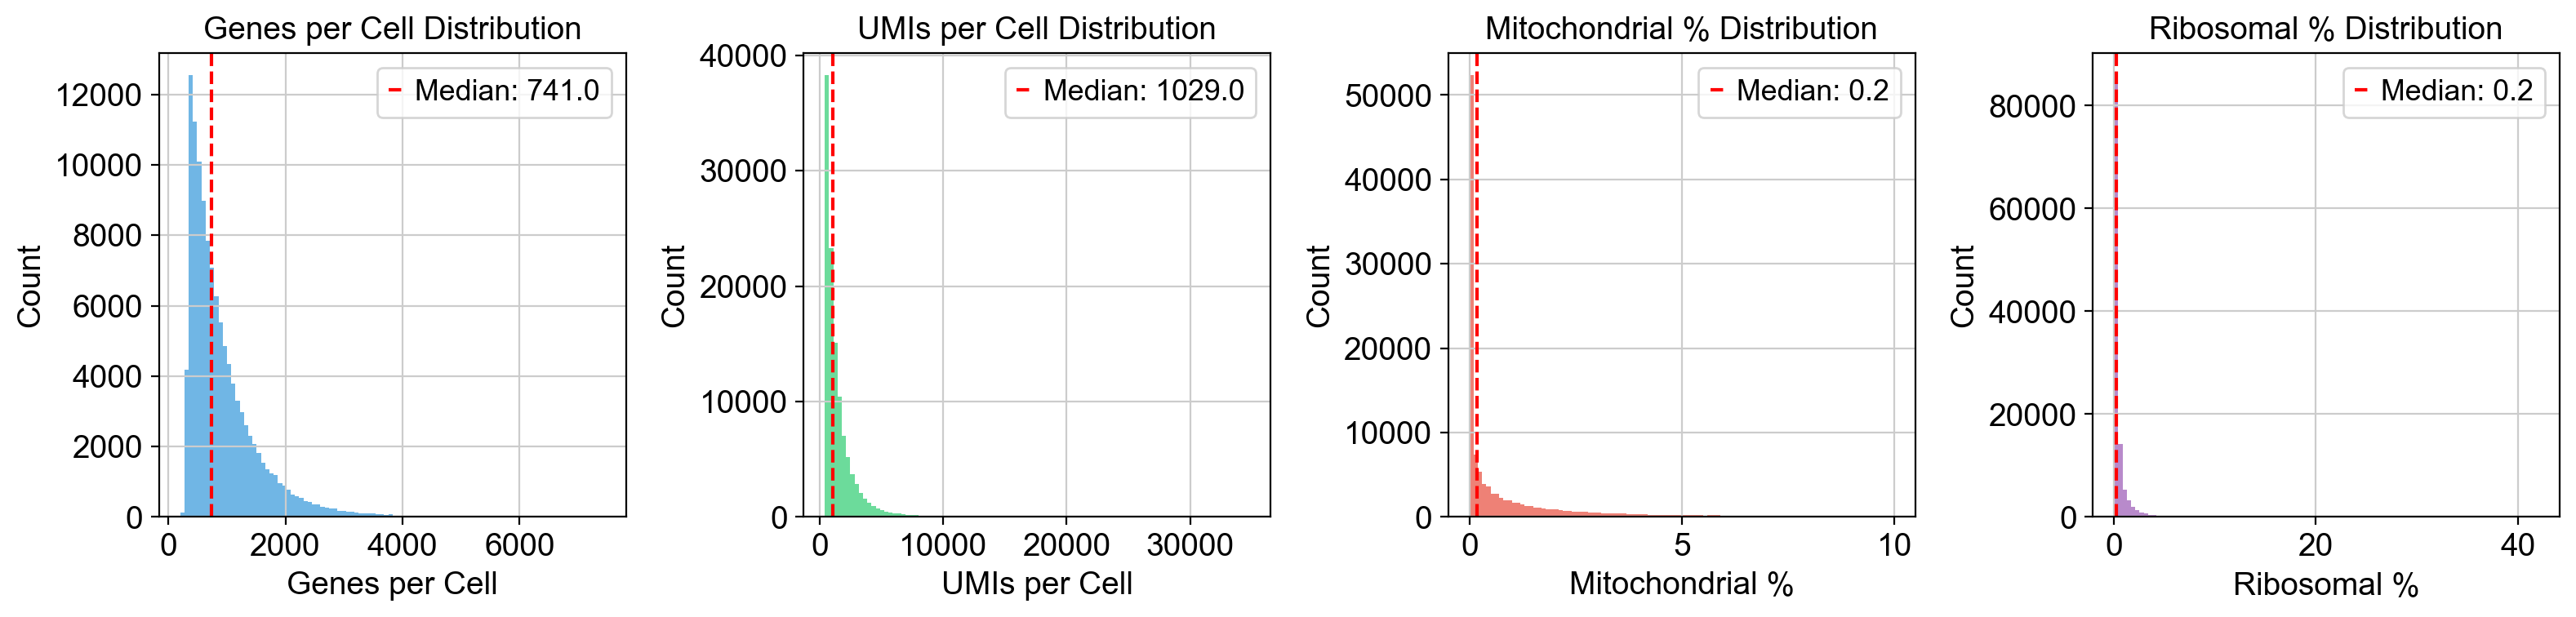

In [6]:
# Overall QC distributions
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

metrics = ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo']
titles = ['Genes per Cell', 'UMIs per Cell', 'Mitochondrial %', 'Ribosomal %']
colors = ['#3498DB', '#2ECC71', '#E74C3C', '#9B59B6']

for ax, metric, title, color in zip(axes, metrics, titles, colors):
    ax.hist(adata.obs[metric], bins=100, color=color, alpha=0.7)
    ax.set_xlabel(title)
    ax.set_ylabel('Count')
    ax.set_title(f'{title} Distribution')
    
    # Add median line
    median = adata.obs[metric].median()
    ax.axvline(median, color='red', linestyle='--', label=f'Median: {median:.1f}')
    ax.legend()

plt.tight_layout()
plt.savefig(FIGURE_DIR / 'qc_distributions.png', dpi=150)
plt.show()

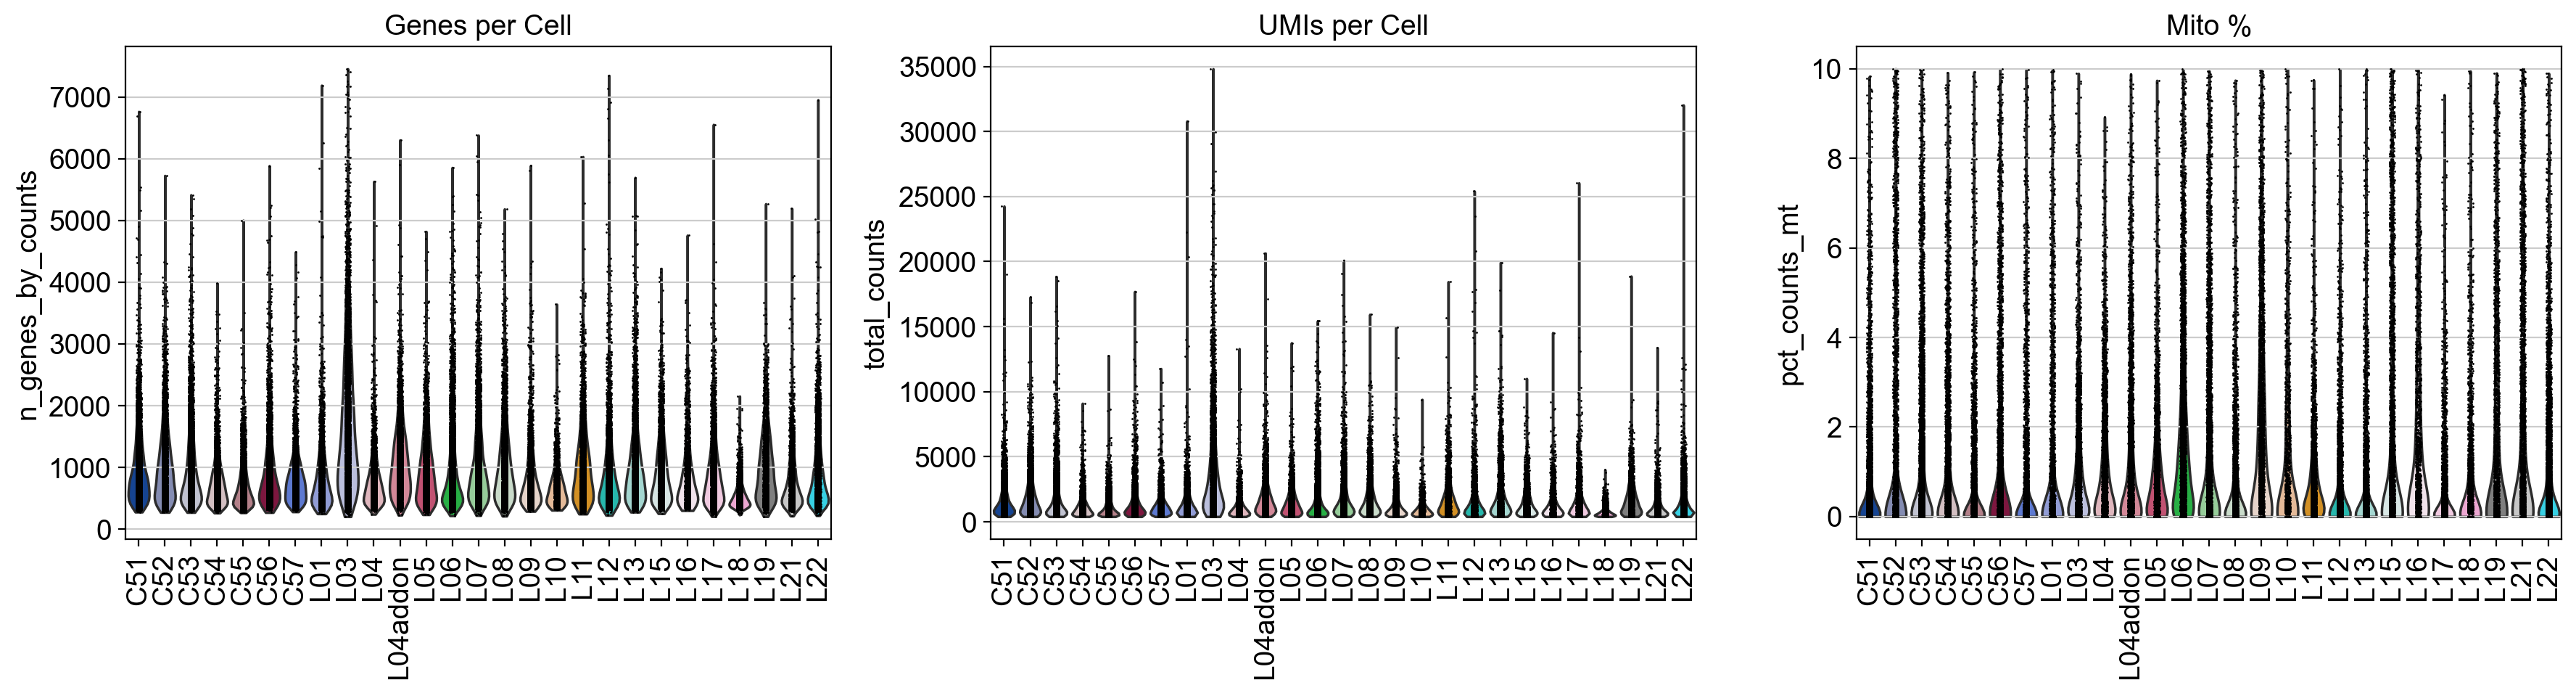

In [7]:
# QC metrics by sample
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, metric, title in zip(axes, 
                             ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
                             ['Genes per Cell', 'UMIs per Cell', 'Mito %']):
    sc.pl.violin(
        adata, 
        metric, 
        groupby='sample_id',
        rotation=90,
        ax=ax,
        show=False
    )
    ax.set_title(title)

plt.tight_layout()
plt.savefig(FIGURE_DIR / 'qc_by_sample.png', dpi=150)
plt.show()

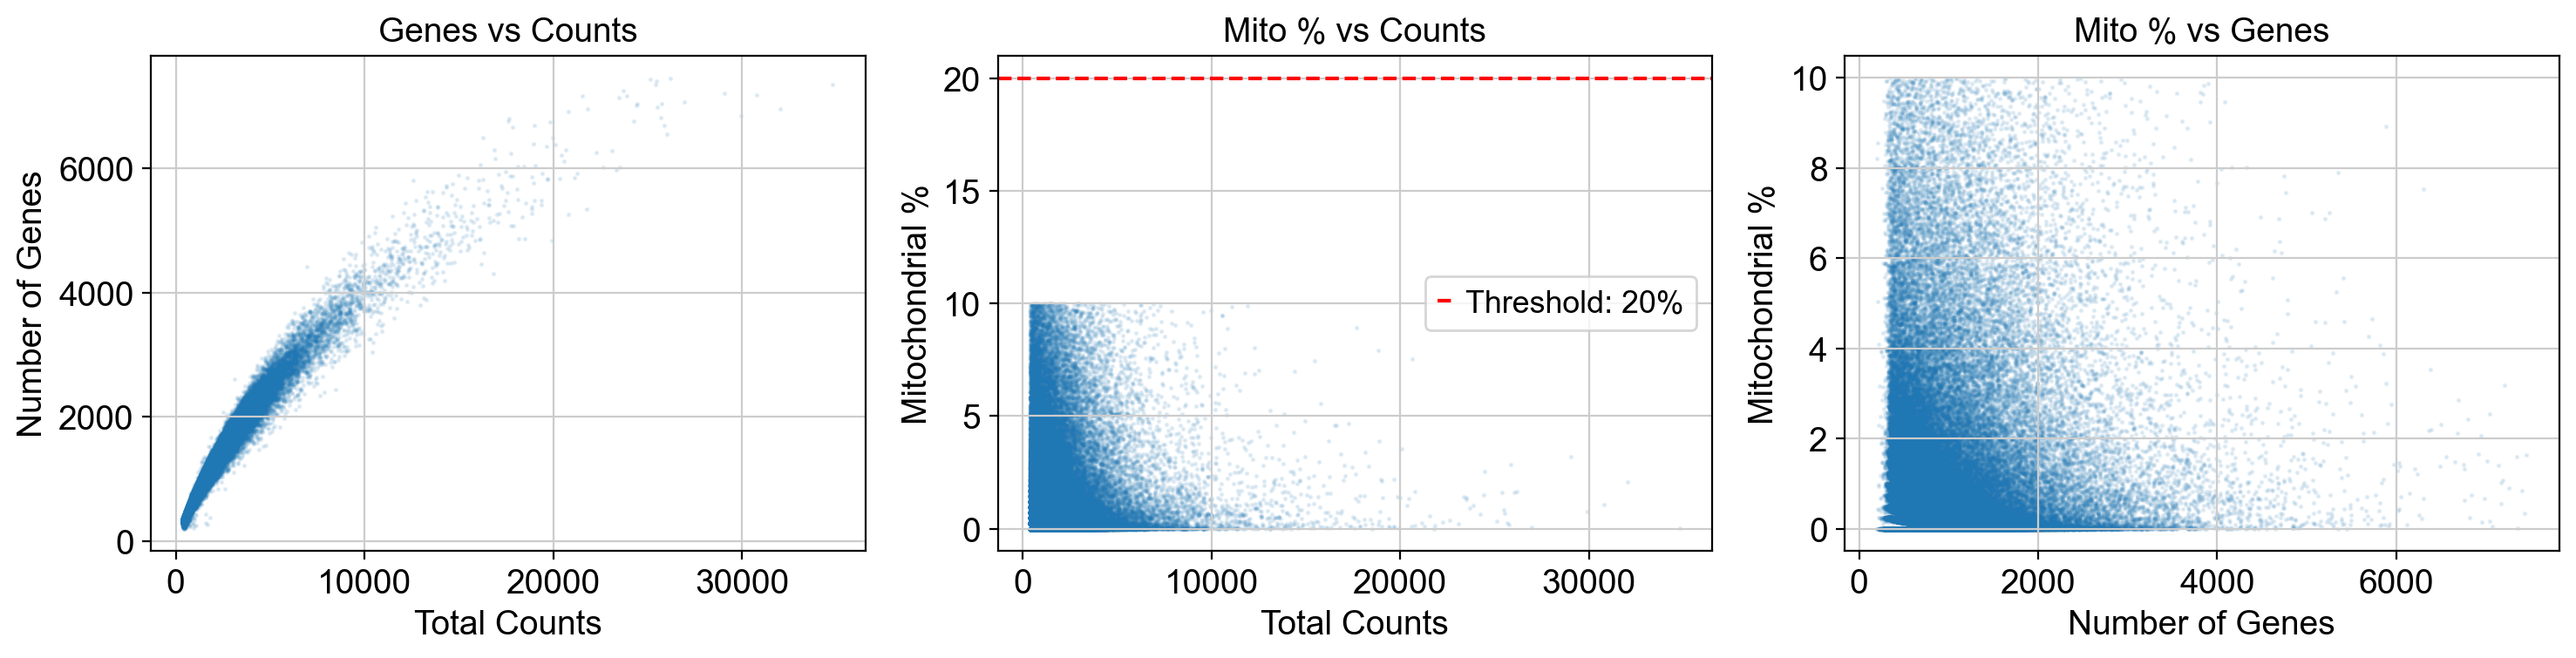

In [8]:
# QC scatter plots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Genes vs counts
axes[0].scatter(adata.obs['total_counts'], adata.obs['n_genes_by_counts'], 
                alpha=0.1, s=1)
axes[0].set_xlabel('Total Counts')
axes[0].set_ylabel('Number of Genes')
axes[0].set_title('Genes vs Counts')

# Mito vs counts
axes[1].scatter(adata.obs['total_counts'], adata.obs['pct_counts_mt'], 
                alpha=0.1, s=1)
axes[1].set_xlabel('Total Counts')
axes[1].set_ylabel('Mitochondrial %')
axes[1].set_title('Mito % vs Counts')
axes[1].axhline(20, color='red', linestyle='--', label='Threshold: 20%')
axes[1].legend()

# Genes vs mito
axes[2].scatter(adata.obs['n_genes_by_counts'], adata.obs['pct_counts_mt'], 
                alpha=0.1, s=1)
axes[2].set_xlabel('Number of Genes')
axes[2].set_ylabel('Mitochondrial %')
axes[2].set_title('Mito % vs Genes')

plt.tight_layout()
plt.savefig(FIGURE_DIR / 'qc_scatter.png', dpi=150)
plt.show()

## MAD-Based Filtering

For snRNA-seq, we use MAD (Median Absolute Deviation) based thresholds rather than fixed cutoffs.
This adapts to the distribution of each sample.

In [9]:
# Define filtering parameters
# More lenient for snRNA-seq
MIN_GENES = 200
MIN_COUNTS = 500
MAX_MITO = 20  # snRNA-seq typically has low mito
N_MADS = 5     # Number of MADs for outlier detection

print("Filtering parameters:")
print(f"  Minimum genes per cell: {MIN_GENES}")
print(f"  Minimum UMIs per cell: {MIN_COUNTS}")
print(f"  Maximum mitochondrial %: {MAX_MITO}")
print(f"  MAD threshold: {N_MADS}")

Filtering parameters:
  Minimum genes per cell: 200
  Minimum UMIs per cell: 500
  Maximum mitochondrial %: 20
  MAD threshold: 5


In [10]:
# Calculate MAD-based upper bounds
def calculate_mad_bounds(values, n_mads=5):
    """Calculate median and MAD-based upper bound."""
    median = np.median(values)
    mad = np.median(np.abs(values - median))
    upper = median + n_mads * mad
    return median, mad, upper

# Calculate bounds for genes and counts
genes_med, genes_mad, genes_upper = calculate_mad_bounds(
    adata.obs['n_genes_by_counts'], N_MADS
)
counts_med, counts_mad, counts_upper = calculate_mad_bounds(
    adata.obs['total_counts'], N_MADS
)

print("MAD-based thresholds:")
print(f"\nGenes per cell:")
print(f"  Median: {genes_med:.0f}")
print(f"  MAD: {genes_mad:.0f}")
print(f"  Upper bound ({N_MADS} MADs): {genes_upper:.0f}")

print(f"\nUMIs per cell:")
print(f"  Median: {counts_med:.0f}")
print(f"  MAD: {counts_mad:.0f}")
print(f"  Upper bound ({N_MADS} MADs): {counts_upper:.0f}")

MAD-based thresholds:

Genes per cell:
  Median: 741
  MAD: 287
  Upper bound (5 MADs): 2176

UMIs per cell:
  Median: 1029
  MAD: 464
  Upper bound (5 MADs): 3349


In [11]:
# Apply filters step by step
n_initial = adata.n_obs

# Filter 1: Minimum genes
filter_min_genes = adata.obs['n_genes_by_counts'] >= MIN_GENES
print(f"Cells with >= {MIN_GENES} genes: {filter_min_genes.sum():,} ({filter_min_genes.mean()*100:.1f}%)")

# Filter 2: Minimum counts
filter_min_counts = adata.obs['total_counts'] >= MIN_COUNTS
print(f"Cells with >= {MIN_COUNTS} UMIs: {filter_min_counts.sum():,} ({filter_min_counts.mean()*100:.1f}%)")

# Filter 3: Maximum genes (MAD-based)
filter_max_genes = adata.obs['n_genes_by_counts'] <= genes_upper
print(f"Cells with <= {genes_upper:.0f} genes: {filter_max_genes.sum():,} ({filter_max_genes.mean()*100:.1f}%)")

# Filter 4: Maximum counts (MAD-based)
filter_max_counts = adata.obs['total_counts'] <= counts_upper
print(f"Cells with <= {counts_upper:.0f} UMIs: {filter_max_counts.sum():,} ({filter_max_counts.mean()*100:.1f}%)")

# Filter 5: Mitochondrial content
filter_mito = adata.obs['pct_counts_mt'] < MAX_MITO
print(f"Cells with < {MAX_MITO}% mito: {filter_mito.sum():,} ({filter_mito.mean()*100:.1f}%)")

# Combine all filters
all_filters = filter_min_genes & filter_min_counts & filter_max_genes & filter_max_counts & filter_mito
print(f"\nCells passing all filters: {all_filters.sum():,} ({all_filters.mean()*100:.1f}%)")

Cells with >= 200 genes: 116,314 (100.0%)
Cells with >= 500 UMIs: 103,168 (88.7%)
Cells with <= 2176 genes: 110,630 (95.1%)
Cells with <= 3349 UMIs: 107,183 (92.1%)
Cells with < 20% mito: 116,314 (100.0%)

Cells passing all filters: 94,027 (80.8%)


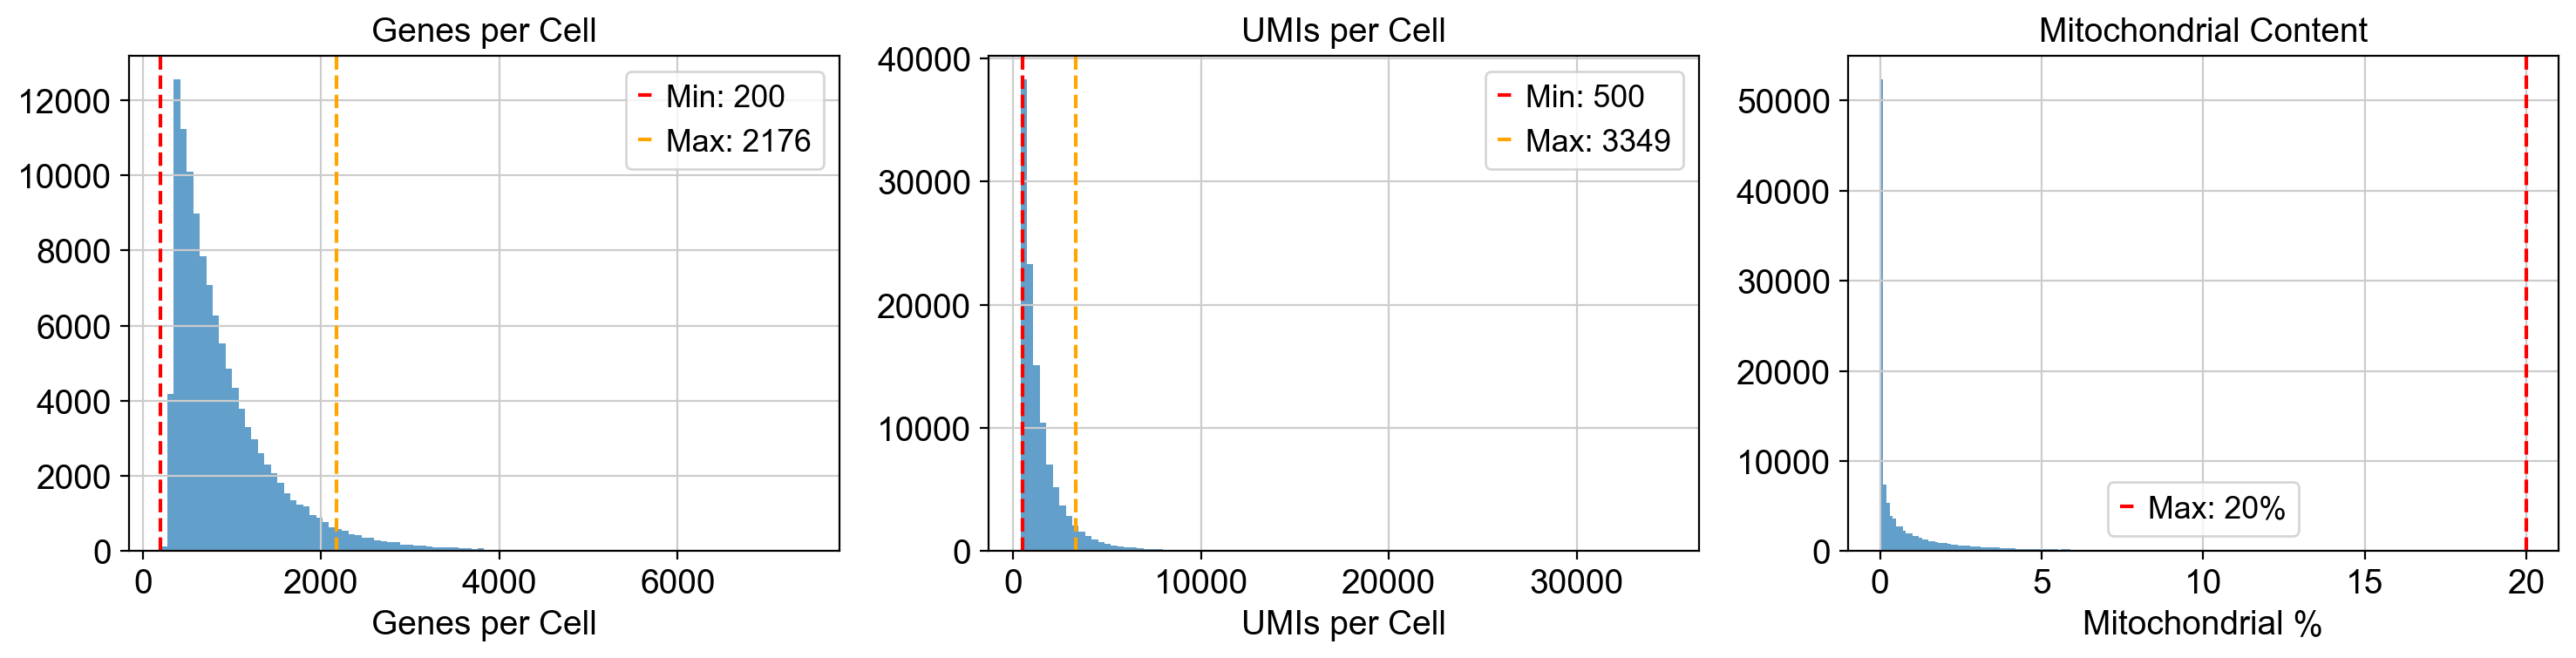

In [12]:
# Visualize filter thresholds
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Genes histogram with thresholds
axes[0].hist(adata.obs['n_genes_by_counts'], bins=100, alpha=0.7)
axes[0].axvline(MIN_GENES, color='red', linestyle='--', label=f'Min: {MIN_GENES}')
axes[0].axvline(genes_upper, color='orange', linestyle='--', label=f'Max: {genes_upper:.0f}')
axes[0].set_xlabel('Genes per Cell')
axes[0].set_title('Genes per Cell')
axes[0].legend()

# Counts histogram with thresholds
axes[1].hist(adata.obs['total_counts'], bins=100, alpha=0.7)
axes[1].axvline(MIN_COUNTS, color='red', linestyle='--', label=f'Min: {MIN_COUNTS}')
axes[1].axvline(counts_upper, color='orange', linestyle='--', label=f'Max: {counts_upper:.0f}')
axes[1].set_xlabel('UMIs per Cell')
axes[1].set_title('UMIs per Cell')
axes[1].legend()

# Mito histogram with threshold
axes[2].hist(adata.obs['pct_counts_mt'], bins=100, alpha=0.7)
axes[2].axvline(MAX_MITO, color='red', linestyle='--', label=f'Max: {MAX_MITO}%')
axes[2].set_xlabel('Mitochondrial %')
axes[2].set_title('Mitochondrial Content')
axes[2].legend()

plt.tight_layout()
plt.savefig(FIGURE_DIR / 'qc_thresholds.png', dpi=150)
plt.show()

## Doublet Detection with Scrublet

In [13]:
import scrublet as scr
import numpy as np

# --- STEP 1: SELECT RAW DATA ---
if adata.raw is not None:
    print("Using data from adata.raw.X")
    input_matrix = adata.raw.X
elif 'counts' in adata.layers:
    print("Using data from adata.layers['counts']")
    input_matrix = adata.layers['counts']
else:
    print("Using adata.X (Ensure this is NOT log-normalized!)")
    input_matrix = adata.X

doublet_scores = np.zeros(adata.n_obs)
predicted_doublets = np.zeros(adata.n_obs, dtype=bool)

# Manual threshold - Scrublet's auto-threshold often fails for snRNA-seq data
# with low complexity. Use 0.25 as default (standard for 10x snRNA-seq).
MANUAL_THRESHOLD = 0.25

# --- STEP 2: RUN SCRUBLET ---
for sample in adata.obs['sample_id'].unique():
    mask = (adata.obs['sample_id'] == sample).values
    indices = np.where(mask)[0]
    
    sample_X = input_matrix[mask]
    
    print(f"Processing {sample}...", end=' ')
    
    try:
        scrub = scr.Scrublet(sample_X, expected_doublet_rate=0.06)
        scores, predictions = scrub.scrub_doublets(verbose=False)
        
        # Check if auto-threshold failed (common with snRNA-seq)
        # Signs: 0 doublets detected, or estimated doublet fraction is NaN
        auto_failed = (predictions is None or 
                       predictions.sum() == 0 or
                       np.isnan(scrub.detected_doublet_rate_))
        
        if auto_failed:
            # Apply manual threshold
            predictions = scores > MANUAL_THRESHOLD
            print(f"{predictions.sum()} doublets (manual threshold={MANUAL_THRESHOLD})")
        else:
            print(f"{predictions.sum()} doublets (auto threshold)")

        doublet_scores[indices] = scores
        predicted_doublets[indices] = predictions
            
    except Exception as e:
        print(f"Error: {e}")

# Save results
adata.obs['doublet_score'] = doublet_scores
adata.obs['predicted_doublet'] = predicted_doublets

total_doublets = predicted_doublets.sum()
print(f"\nTotal doublets detected: {total_doublets:,} ({total_doublets/adata.n_obs*100:.1f}%)")

Using adata.X (Ensure this is NOT log-normalized!)
Processing C51... 0 doublets (manual threshold=0.25)
Processing C52... 0 doublets (manual threshold=0.25)
Processing C53... 0 doublets (manual threshold=0.25)
Processing C54... 0 doublets (manual threshold=0.25)
Processing C55... 0 doublets (manual threshold=0.25)
Processing C56... 0 doublets (manual threshold=0.25)
Processing C57... 0 doublets (manual threshold=0.25)
Processing L01... 0 doublets (manual threshold=0.25)
Processing L03... 0 doublets (manual threshold=0.25)
Processing L04... 0 doublets (manual threshold=0.25)
Processing L04addon... 0 doublets (manual threshold=0.25)
Processing L05... 0 doublets (manual threshold=0.25)
Processing L06... 0 doublets (manual threshold=0.25)
Processing L07... 0 doublets (manual threshold=0.25)
Processing L08... 0 doublets (manual threshold=0.25)
Processing L09... 0 doublets (manual threshold=0.25)
Processing L10... 0 doublets (manual threshold=0.25)
Processing L11... 0 doublets (manual thresh

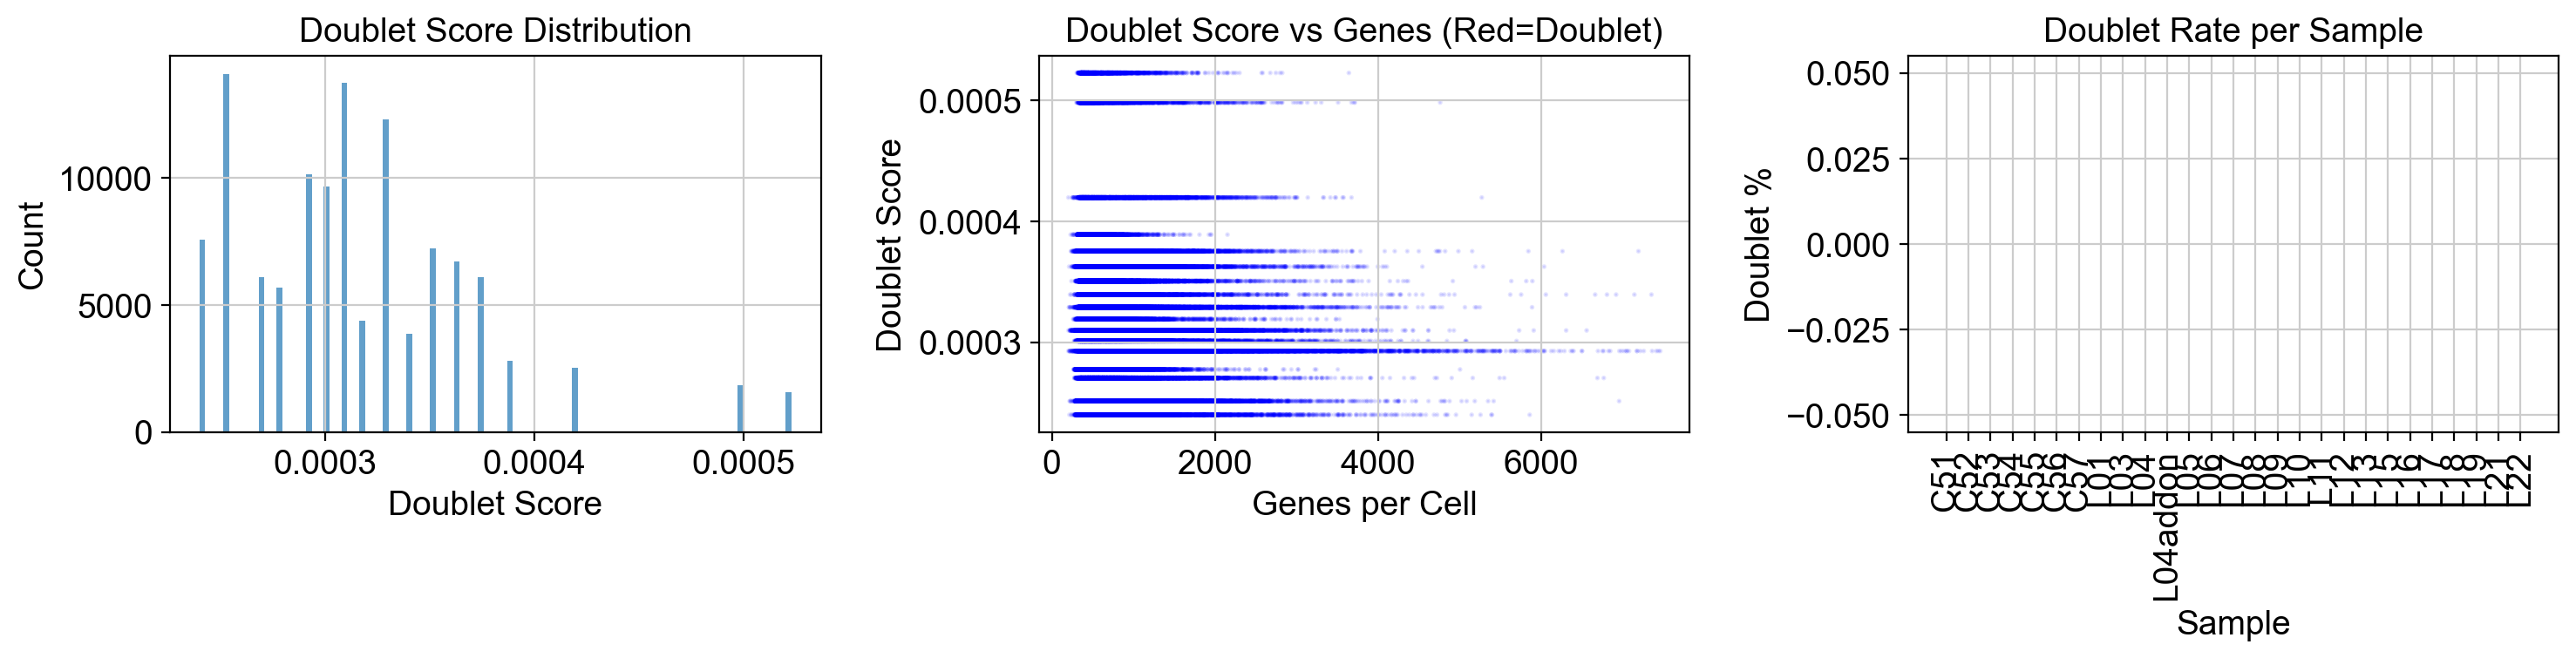

In [35]:
# Visualize doublet detection
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Doublet score distribution
axes[0].hist(adata.obs['doublet_score'], bins=100, alpha=0.7)
axes[0].set_xlabel('Doublet Score')
axes[0].set_ylabel('Count')
axes[0].set_title('Doublet Score Distribution')

# Doublet score vs genes
colors = ['red' if d else 'blue' for d in adata.obs['predicted_doublet']]
axes[1].scatter(
    adata.obs['n_genes_by_counts'],
    adata.obs['doublet_score'],
    c=colors, alpha=0.1, s=1
)
axes[1].set_xlabel('Genes per Cell')
axes[1].set_ylabel('Doublet Score')
axes[1].set_title('Doublet Score vs Genes (Red=Doublet)')

# Doublets per sample
doublet_counts = adata.obs.groupby('sample_id')['predicted_doublet'].sum()
total_counts = adata.obs.groupby('sample_id').size()
doublet_pct = (doublet_counts / total_counts * 100).sort_index()
axes[2].bar(range(len(doublet_pct)), doublet_pct.values)
axes[2].set_xticks(range(len(doublet_pct)))
axes[2].set_xticklabels(doublet_pct.index, rotation=90)
axes[2].set_xlabel('Sample')
axes[2].set_ylabel('Doublet %')
axes[2].set_title('Doublet Rate per Sample')

plt.tight_layout()
plt.savefig(FIGURE_DIR / 'doublet_detection.png', dpi=150)
plt.show()

## Apply All Filters

In [36]:
# Combine QC filters with doublet filter
filter_doublet = ~adata.obs['predicted_doublet']

final_filter = all_filters & filter_doublet

print("Filtering summary:")
print(f"  Initial cells: {n_initial:,}")
print(f"  After QC filters: {all_filters.sum():,}")
print(f"  After doublet removal: {final_filter.sum():,}")
print(f"  Total removed: {n_initial - final_filter.sum():,} ({(1 - final_filter.mean())*100:.1f}%)")

Filtering summary:
  Initial cells: 116,314
  After QC filters: 94,027
  After doublet removal: 94,027
  Total removed: 22,287 (19.2%)


In [37]:
# Apply filters
adata_qc = adata[final_filter].copy()

print(f"\nFiltered AnnData:")
print(f"  Cells: {adata_qc.n_obs:,}")
print(f"  Genes: {adata_qc.n_vars:,}")


Filtered AnnData:
  Cells: 94,027
  Genes: 34,546


In [38]:
# Filter genes (minimum cells per gene)
MIN_CELLS_PER_GENE = 10

n_genes_before = adata_qc.n_vars
sc.pp.filter_genes(adata_qc, min_cells=MIN_CELLS_PER_GENE)

print(f"Gene filtering (min {MIN_CELLS_PER_GENE} cells):")
print(f"  Before: {n_genes_before:,}")
print(f"  After: {adata_qc.n_vars:,}")
print(f"  Removed: {n_genes_before - adata_qc.n_vars:,}")

filtered out 5496 genes that are detected in less than 10 cells
Gene filtering (min 10 cells):
  Before: 34,546
  After: 29,050
  Removed: 5,496


In [39]:
# QC summary by condition
print("\nFiltered cells by condition:")
print(adata_qc.obs['condition'].value_counts())

print("\nFiltered cells by sample:")
sample_counts = adata_qc.obs.groupby(['sample_id', 'condition']).size().reset_index(name='n_cells')
print(sample_counts.to_string(index=False))


Filtered cells by condition:
condition
COVID      63649
Control    30378
Name: count, dtype: int64

Filtered cells by sample:
sample_id condition  n_cells
      C51     COVID        0
      C51   Control     5151
      C52     COVID        0
      C52   Control     3579
      C53     COVID        0
      C53   Control     5657
      C54     COVID        0
      C54   Control     3688
      C55     COVID        0
      C55   Control     4690
      C56     COVID        0
      C56   Control     3380
      C57     COVID        0
      C57   Control     4233
      L01     COVID     2507
      L01   Control        0
      L03     COVID     3033
      L03   Control        0
      L04     COVID     3051
      L04   Control        0
 L04addon     COVID     3861
 L04addon   Control        0
      L05     COVID     2557
      L05   Control        0
      L06     COVID     5764
      L06   Control        0
      L07     COVID     4117
      L07   Control        0
      L08     COVID     3440
   

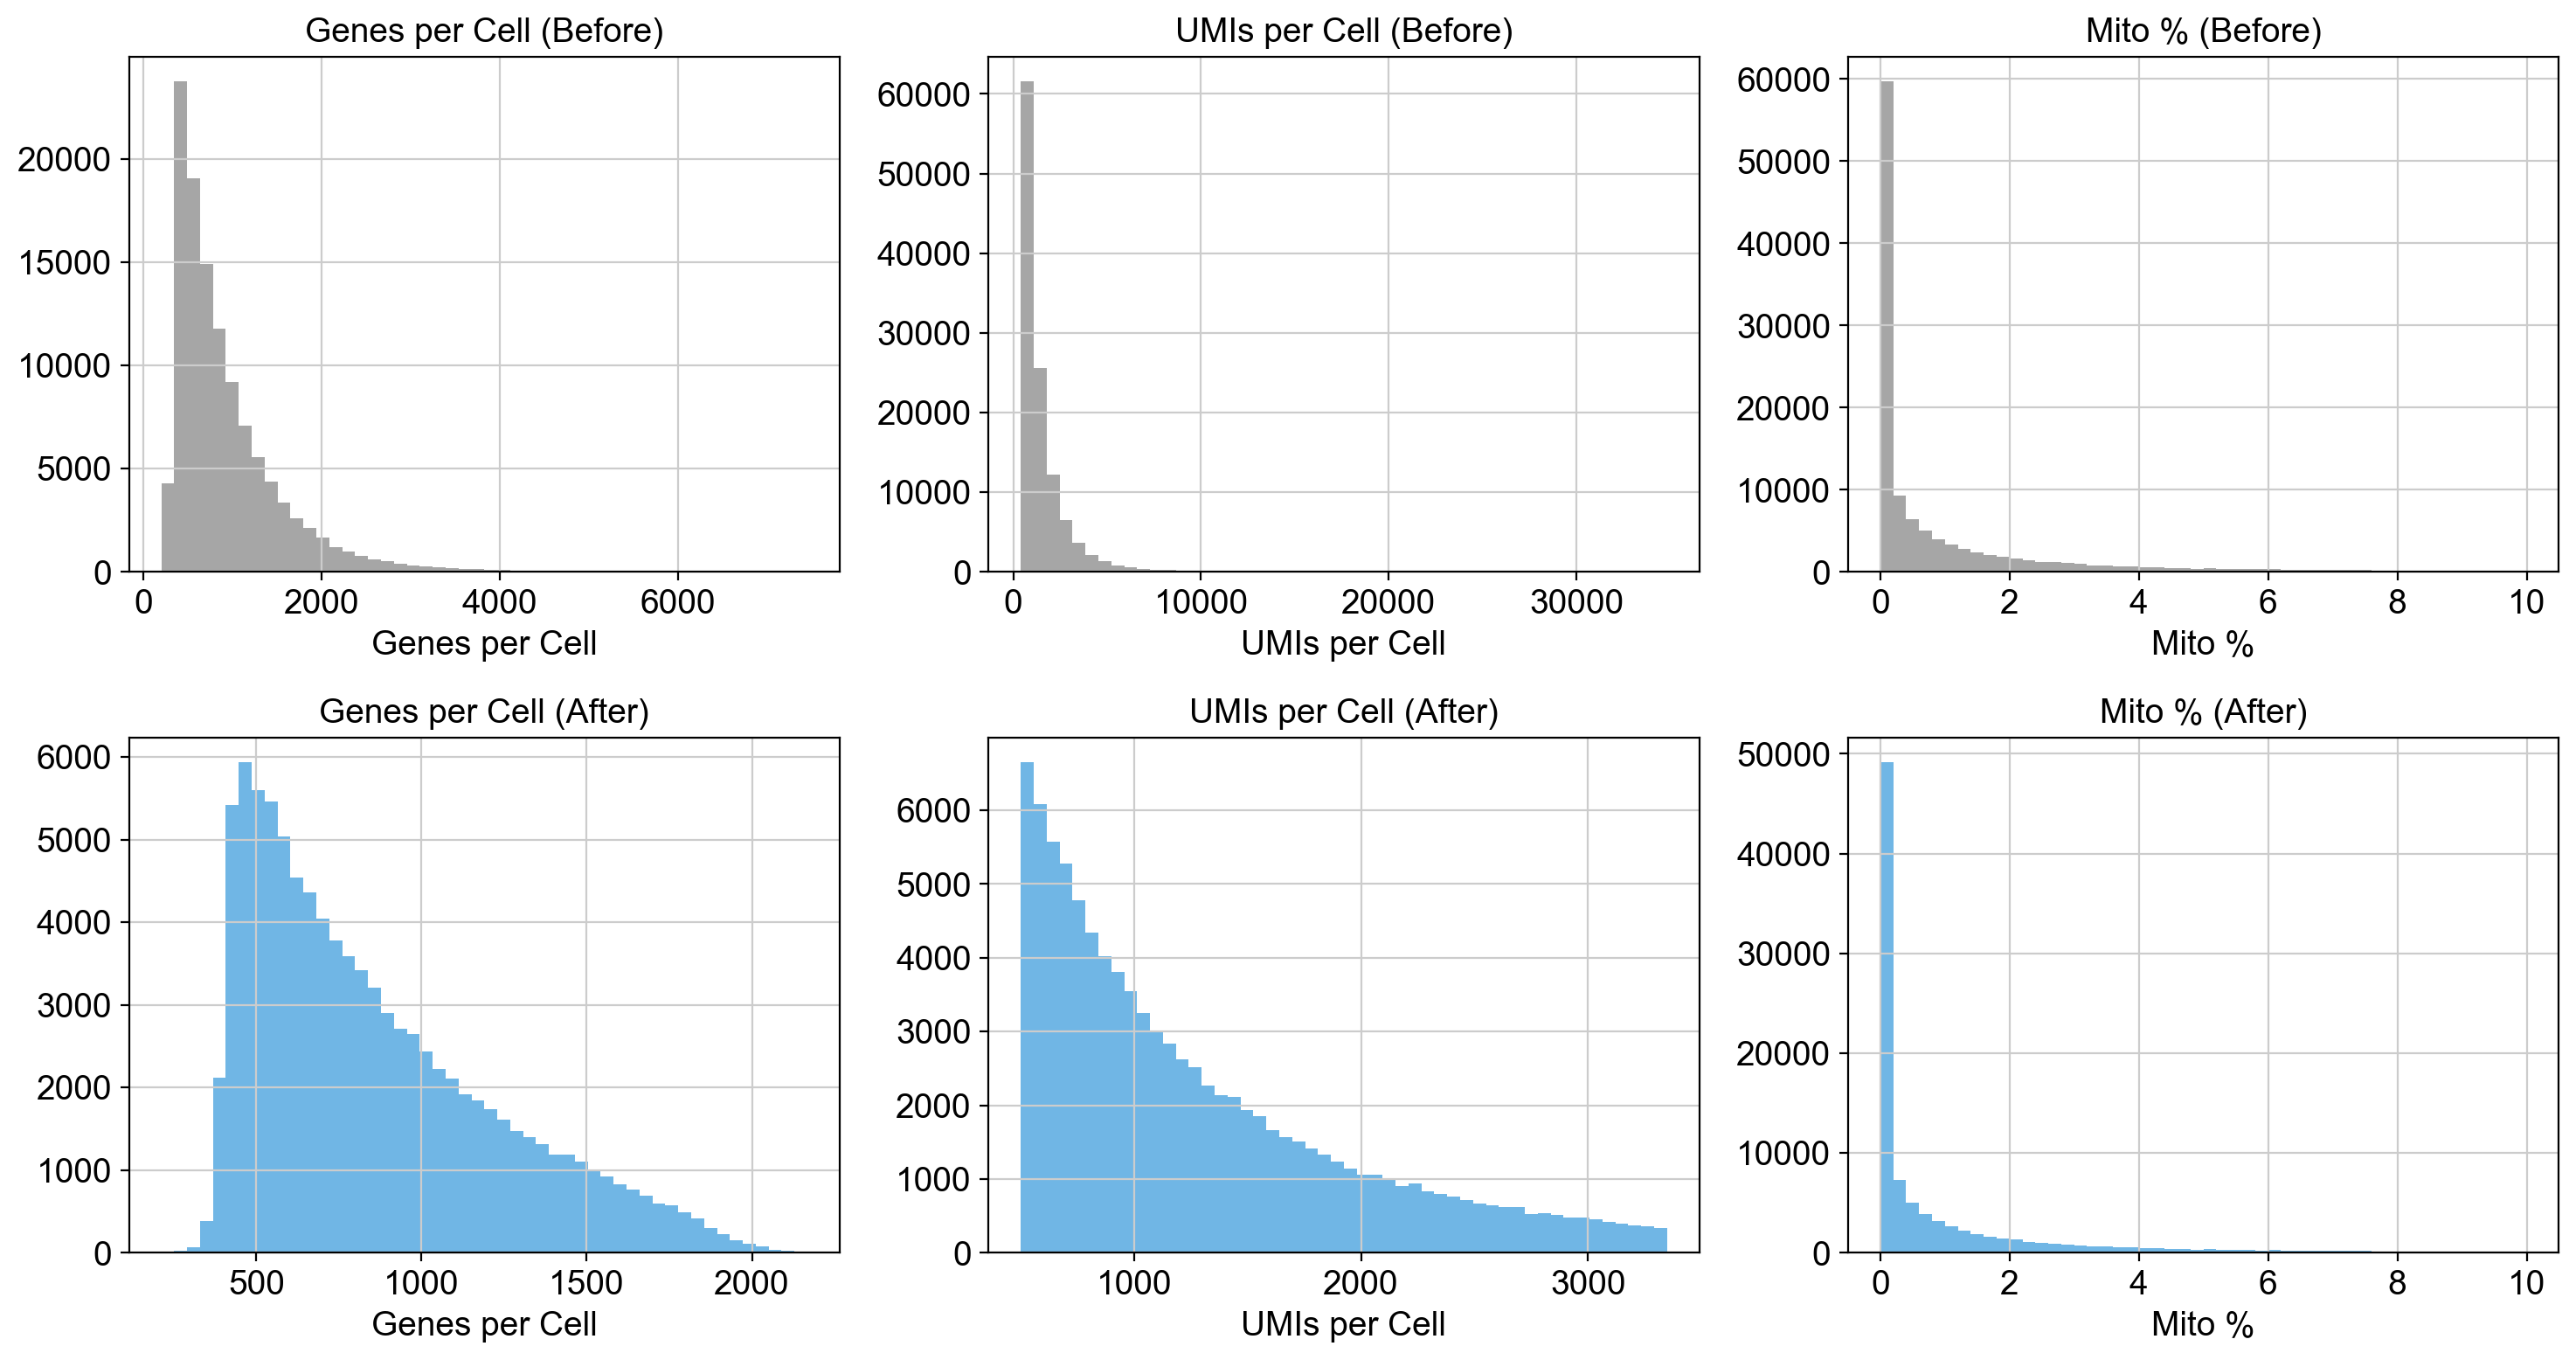

In [40]:
# Compare QC metrics before and after
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

metrics = ['n_genes_by_counts', 'total_counts', 'pct_counts_mt']
titles = ['Genes per Cell', 'UMIs per Cell', 'Mito %']

for col, (metric, title) in enumerate(zip(metrics, titles)):
    # Before
    axes[0, col].hist(adata.obs[metric], bins=50, alpha=0.7, color='gray')
    axes[0, col].set_title(f'{title} (Before)')
    axes[0, col].set_xlabel(title)
    
    # After
    axes[1, col].hist(adata_qc.obs[metric], bins=50, alpha=0.7, color='#3498DB')
    axes[1, col].set_title(f'{title} (After)')
    axes[1, col].set_xlabel(title)

plt.tight_layout()
plt.savefig(FIGURE_DIR / 'qc_before_after.png', dpi=150)
plt.show()

In [41]:
# Post-QC statistics
print("Post-QC statistics:")
print(adata_qc.obs[qc_cols[:3]].describe())

Post-QC statistics:
       n_genes_by_counts  total_counts  pct_counts_mt
count       94027.000000  94027.000000   94027.000000
mean          856.551437   1274.114624       0.985895
std           372.538390    685.248291       1.756727
min           212.000000    500.000000       0.000000
25%           553.000000    726.000000       0.000000
50%           762.000000   1064.000000       0.166852
75%          1083.000000   1645.000000       1.136364
max          2168.000000   3349.000000       9.996541


In [42]:
# Save QC'd data
output_path = OUTPUT_DIR / 'adata_qc.h5ad'

print(f"Saving to: {output_path}")
adata_qc.write_h5ad(output_path, compression='gzip')

print(f"\nFile saved: {output_path}")
print(f"File size: {output_path.stat().st_size / 1e9:.2f} GB")

Saving to: ../data/processed_data/adata_qc.h5ad

File saved: ../data/processed_data/adata_qc.h5ad
File size: 0.19 GB


In [43]:
# Save QC summary table
qc_summary = pd.DataFrame({
    'sample_id': adata.obs['sample_id'].unique(),
})

# Add before counts
before_counts = adata.obs.groupby('sample_id').size()
qc_summary['cells_before'] = qc_summary['sample_id'].map(before_counts)

# Add after counts
after_counts = adata_qc.obs.groupby('sample_id').size()
qc_summary['cells_after'] = qc_summary['sample_id'].map(after_counts).fillna(0).astype(int)

# Add removal rate
qc_summary['removal_rate'] = (1 - qc_summary['cells_after'] / qc_summary['cells_before']) * 100

# Add condition
condition_map = adata.obs.groupby('sample_id')['condition'].first()
qc_summary['condition'] = qc_summary['sample_id'].map(condition_map)

qc_summary = qc_summary.sort_values('condition')

print("QC Summary by Sample:")
print(qc_summary.to_string(index=False))

# Save
qc_summary.to_csv(OUTPUT_DIR / 'qc_summary.csv', index=False)

TypeError: Cannot setitem on a Categorical with a new category (0), set the categories first

## Summary

### Quality Control Applied
- **Minimum genes per cell**: 200
- **Minimum UMIs per cell**: 500
- **Maximum genes per cell**: MAD-based (5 MADs above median)
- **Maximum UMIs per cell**: MAD-based (5 MADs above median)
- **Maximum mitochondrial %**: 20%
- **Doublet removal**: Scrublet per sample

### Results
- See summary table above for per-sample filtering

### Output
- `data/processed_data/adata_qc.h5ad` - QC'd AnnData
- `data/processed_data/qc_summary.csv` - QC statistics

### Next Steps
→ **03_integration_scvi.ipynb**: Batch correction and integration with scVI

In [ ]:
# Session info
print("\n=== Session Info ===")
print(f"Scanpy: {sc.__version__}")
print(f"AnnData: {ad.__version__}")
print(f"NumPy: {np.__version__}")
print(f"Pandas: {pd.__version__}")